# PART 1. Installation and Configuration

## STEP 1. Configuration

### Google Drive

In [0]:
# This cell imports the drive library and mounts your Google Drive as a VM local drive. You can access to your Drive files 
# using this path "/content/gdrive/My Drive/"

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# List the content of your local computer folder 
!ls -la "/content/gdrive/My Drive/darknet"

### GPU

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

## STEP 2. Check CUDA release version

Nvidia CUDA is pre-installed on Colab notebooks. Now we'll check the version installed.

> _**BE AWARE:** Maybe some time from the time I'm writing these lines (April 9th, 2019)  the CUDA version is upgraded on Colab and you should download another version of the cuDNN in the next step. Now is release 10.0 and we are using cuDNN (cudnn-10.0-linux-x64-v7.5.0.56.tgz) accordingly_

In [0]:
# This cell can be commented once you checked the current CUDA version
# CUDA: Let's check that Nvidia CUDA is already pre-installed and which version is it. In some time from now maybe you 
!/usr/local/cuda/bin/nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


## STEP 3. Install cuDNN according to the current CUDA version
Now, you need to download cuDNN from Nvidia web site. You'll need to sign up on the site.

* Download cuDNN from [Nvidia website](https://developer.nvidia.com/cudnn) 
* Download cuDNN from [Alternative](http://people.cs.uchicago.edu/~kauffman/nvidia/cudnn/)

  * Right now, because we have _**CUDA 10.0**_ preinstalled in Colab runtime, you need download [cuDNN v7.5.0.56 for CUDA v10.0](https://developer.nvidia.com/compute/machine-learning/cudnn/secure/v7.5.0.56/prod/10.0_20190219/cudnn-10.0-linux-x64-v7.5.0.56.tgz) - the file is **(cudnn-10.0-linux-x64-v7.5.0.56.tgz)**

* On your local computer, create a folder named _**cuDNN**_ in your local folder _**darknet**_. Copy the _**tgz**_ file there 



In [0]:
# We're unzipping the cuDNN files from your Drive folder directly to the VM CUDA folders
!tar -xzvf gdrive/My\ Drive/darknet/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# Now we check the version we already installed. Can comment this line on future runs
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

## STEP 4. Cloning and compiling Darknet. ONLY NEEDS TO BE RUN ON THE FIRST EXECUTION!!
In this step we'll clone the darkent repo and compile it. 
* Clone Repo
* Compile Darknet
* Copy compiled version to Drive

When compiling ends, your output last line has to be something like this:

_`g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU (...)_`

In [0]:
# Leave this code uncommented on the very first run of your notebook or if you ever need to recompile darknet again.
# Comment this code on the future runs.
!git clone https://github.com/kriyeng/darknet/
%cd darknet

# Check the folder
!ls

# I have a branch where I have done the changes commented above
!git checkout feature/google-colab

#Compile Darknet
!make

#Copies the Darknet compiled version to Google drive
!cp ./darknet /content/gdrive/My\ Drive/darknet/bin/darknet

In [0]:
# Not necessary cell
# Get yolov3 weights
!wget https://pjreddie.com/media/files/yolov3.weights

In [0]:
# Not necessary cell
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects on 'person.jpg'
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg -dont-show

# Show the result using the helper imgShow()
imShow('predictions.jpg')

## Some Utils
Let's add some utils that maybe can be useful.

These utils are:
* imgShow() - Will help us to show an image in the remote VM
* download() - Will allow you to get some file from your notebook in case you need to
* upload() - You can upload files to your current folder on the remote VM.

Thanks to [Ivan Goncharov](https://twitter.com/Ivangrov) for these helpers!

In [0]:
#download files
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
def download(path):
  from google.colab import files
  files.download(path)

# PART 2 - Train and Test  

## STEP 1. Preparing your data and configuration files 

Before going further let's take a look at what configuration files you need to have in your local drive _`darknet`_

![Yolov3 configuration files cheat sheet.jpg](http://blog.ibanyez.info/download/B20190410T000000072.png)

You can download the cheat sheet [here](http://blog.ibanyez.info/download/B20190410T000000072.png)

If you need deeper explanations on how to prepare your data sets, annotation and deep learning, visit [How to train YOLOv3 using Darknet framework and optimize the VM runtime load times](post link)


> **TRICK:** You have to be carefully configuring paths on your config files. _*obj.data*_ file needs to have spaces on the path escaped with _**\**_. Like this: **_/content/gdrive/My\ Drive/darknet/train.txt_**. But, in files **_train.txt_** and **_test.txt_** does not!




## STEP 2. Copying files from Google Drive to VM local filesystem.
Execute the follow cell to copy your files

In [0]:
# Copy fils from Google Drive to the VM local filesystem
!cp -r "/content/gdrive/My Drive/darknet/img" ./img


In [0]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

In [0]:
!cp ./darknet53.conv.74 "/content/gdrive/My Drive/darknet/"

## STEP 3. Finally, Train your model!

When you execute the following command, your model will start training.

You will have a log line per epoch. On each iteration you will see how your training is going.

> **TRICK: Darknet copies a backup of your trained weights every 100 iterations. As magic, this file will be synced to your local drive on your computer, as well as the backups darknet do every 1000 iterations, saving it on a separate file.**





In [0]:
!./darknet detector train "/content/gdrive/My Drive/darknet/obj.data" "/content/gdrive/My Drive/darknet/cfg/yolov3.cfg" "/content/gdrive/My Drive/darknet/darknet53.conv.74" -dont_show 

### PERFORMANCE TIPS & TRICKS

* **Speed up load times of the runtime:** When everything is checked that works, you can remove cells or comment unnecessary lines of code to make your loading time lower on every run. 

* **How to keep your notebook alive for more time?:** Keep you browser with your notebook open. If you close your browser, your notebook will reach the iddle time and will be removed from Colab cloud Service. (90 minutes)
  
* **Re-run your training after reaching the limitation time for Colab runtimes (12 hours):** 
  * Open a new notebook or reconnect the current one.
  * Comment the cell above and uncomment the cell below.
  * In your local computer, copy the file **backup/yolov3_last.weights** to your local computer **weights/** folder. 
  * Execute Run all in the **> menu > Runtime > Run All**
  * _The copy step is not absolutely necessary, but I like to keep a copy of the last training session and not overwrite this file on next trainings._

In [0]:
# Start training at the point where the last runtime finished
!./darknet detector train "/content/gdrive/My Drive/darknet/obj.data" "/content/gdrive/My Drive/darknet/cfg/yolov3.cfg" "/content/gdrive/My Drive/darknet/backup/yolov3_last.weights" -dont_show 

## STEP 4. Test 

In [0]:
!./darknet detector test "/content/gdrive/My Drive/darknet/obj.data" "/content/gdrive/My Drive/darknet/cfg/yolov3.cfg" "/content/gdrive/My Drive/darknet/backup/yolov3_3000.weights" "/content/gdrive/My Drive/darknet/img/pic133.jpg"

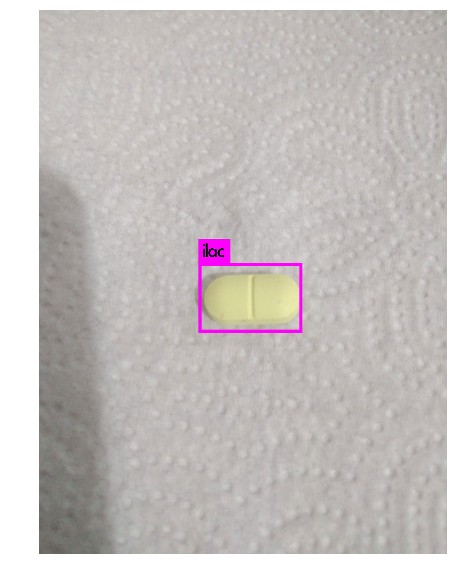

In [16]:
imShow('predictions.jpg')